# Fine Tune Stable Diffusion

Fine tuning Stable Diffusion on Pokemon, 
for more details see the [Lambda Labs examples repo](https://github.com/LambdaLabsML/examples). 

We recommend using a multi-GPU machine, for example an instance from [Lambda GPU Cloud](https://lambdalabs.com/service/gpu-cloud). If running on Colab this notebook is likely to need a GPU with >16GB of VRAM and a runtime with high RAM, which will almost certainly need Colab Pro or Pro+. (If you get errors suchs as `Killed` or `CUDA out of memory` then one of these is not sufficient)

In [1]:
!git clone https://github.com/justinpinkney/stable-diffusion.git
%cd stable-diffusion
!pip install --upgrade pip
!pip install -r requirements.txt

#!pip install --upgrade keras # on lambda stack we need to upgrade keras
#!pip uninstall -y torchtext # on colab we need to remove torchtext

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 1747, done.
remote: Total 1747 (delta 0), reused 0 (delta 0), pack-reused 1747
Receiving objects: 100% (1747/1747), 73.93 MiB | 45.60 MiB/s, done.
Resolving deltas: 100% (1079/1079), done.
/home/ubuntu/stable-diffusion
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.8 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3
    Uninstalling pip-22.3:
      Successfully uninstalled pip-22.3
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers (from -r requirements.txt (line 23))
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-

In [2]:
!pip install typing-extensions==4.5.0

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
ERROR: pip's depen

In [3]:
!nvidia-smi

Wed Nov 22 22:40:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:05:00.0 Off |                  Off |
| 30%   30C    P8     6W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:06:00.0 Off |                  Off |
| 30%   

In [5]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Using custom data configuration msklar--skribbl-drawings-ef5b50e1518e7dbc


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/msklar___parquet/msklar--skribbl-drawings-ef5b50e1518e7dbc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


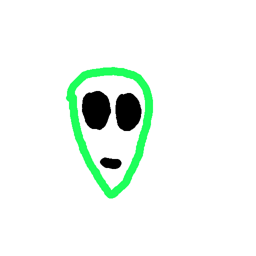

alien


In [6]:
# Check the dataset
from datasets import load_dataset
ds = load_dataset("msklar/skribbl-drawings", split='train')

sample = ds[0]
display(sample["image"].resize((256, 256)))
print(sample["text"])

To get the weights you need to you'll need to [go to the model card](https://huggingface.co/CompVis/stable-diffusion-v1-4-original), read the license and tick the checkbox if you agree.

In [7]:
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", filename="sd-v1-4-full-ema.ckpt", use_auth_token=True)

sd-v1-4-full-ema.ckpt:   0%|          | 0.00/7.70G [00:00<?, ?B/s]

Set your parameters below depending on your GPU setup, the settings below were used for training on a 2xA6000 machine, (the A6000 has 48GB of VRAM). On this set up good results are achieved in around 6 hours.

You can make up for using smaller batches or fewer gpus by accumulating batches:

`total batch size = batach size * n gpus * accumulate batches`

In [8]:
"""
# 1xA100:
BATCH_SIZE = 4
N_GPUS = 1
ACCUMULATE_BATCHES = 1
"""

# 4xA6000:
BATCH_SIZE = 4
N_GPUS = 4
ACCUMULATE_BATCHES = 1

gpu_list="0"

if N_GPUS > 1:
  gpu_list = ",".join((str(x) for x in range(N_GPUS))) + ","
else:
  gpu_list = "0"

print(f"Using GPUs: {gpu_list}")

Using GPUs: 0,1,2,3,


In [9]:
!pip install opencv-python==4.8.0.74
!pip install --upgrade --force-reinstall git+https://github.com/arogozhnikov/einops.git
!pip install Pillow==9.5.0

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 71.4 MB/s eta 0:00:00:00:0100:01
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.5.64
    Uninstalling opencv-python

In [17]:
# if a protobuf warning pops up in the following cell, run this:
#!pip install protobuf==3.20.*

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.0 MB/s eta 0:00:00
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully 

In [42]:
"""
# 1xA100
# Run training
!(python main.py \
    -t \
    --base ../skribbl.yaml \
    --gpus="1" \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
)
"""

# 4xA6000
# Run training
!(python main.py \
    -t \
    --base ../skribbl.yaml \
    --gpus "$gpu_list" \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
    data.params.validation.params.n_gpus="$N_GPUS" \
)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Global seed set to 23
Running on GPUs 0,1,2,3,
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.18.mlp.fc2.weight', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.en

In [43]:
%ls ../checkpoints

'epoch=1-step=29.ckpt'      'epoch=44-step=674.ckpt'
'epoch=1.ckpt'              'epoch=59-step=899.ckpt'
'epoch=104-step=1574.ckpt'  'epoch=74-step=1124.ckpt'
'epoch=14-step=224.ckpt'    'epoch=89-step=1349.ckpt'
'epoch=29-step=449.ckpt'     last.ckpt


In [50]:
# Run the model
!(python scripts/txt2img.py \
    --prompt 'simple microsoft paint drawing of a smile on a solid white background' \
    --outdir '../outputs/generated_drawings' \
    --H 512 --W 512 \
    --n_samples 4 \
    --config '../skribbl.yaml' \
    --ckpt "../checkpoints/epoch=104-step=1574.ckpt")

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Global seed set to 42
Loading model from ../checkpoints/epoch=104-step=1574.ckpt
Global Step: 1575
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.self_attn.out_proj.weight', 'vision_model.encoder.layers.23.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.21.mlp.fc1.bias', 'vision_model.encoder.layers.23.layer_

In [38]:
%cd ../checkpoints

/home/ubuntu/checkpoints


In [39]:
%ls

'epoch=1-step=29.ckpt'  'epoch=1.ckpt'   last.ckpt


In [40]:
%cd ../stable-diffusion

/home/ubuntu/stable-diffusion
